In [1]:
import napari
import matplotlib.pyplot as plt
from napari_video.napari_video import VideoReaderNP
import glob
import pandas as pd
import numpy as np
import warnings
# from tqdm import tqdm
# import os
warnings.filterwarnings("ignore")

In [2]:
def removeROI_allFrames(df, roi):
    df2 = df.copy()
    scorer = df.columns.get_level_values(0)[0]
    x_min = roi[:,1].min()
    x_max = roi[:,1].max()
    y_min = roi[:,0].min()
    y_max = roi[:,0].max()
    for ind in df2.columns.get_level_values(1).unique():
        for bp in df2.columns.get_level_values(2).unique():
            df2[scorer, ind, bp, 'x'].loc[(df2[scorer, ind, bp, 'x'] > x_min) & 
                                               (df2[scorer, ind, bp, 'x'] < x_max) & 
                                               (df2[scorer, ind, bp, 'y'] > y_min) & 
                                               (df2[scorer, ind, bp, 'y'] < y_max) ] = np.nan

            df2[scorer, ind, bp, 'y'].loc[(df2[scorer, ind, bp, 'x'] > x_min) & 
                                               (df2[scorer, ind, bp, 'x'] < x_max) & 
                                               (df2[scorer, ind, bp, 'y'] > y_min) & 
                                               (df2[scorer, ind, bp, 'y'] < y_max) ] = np.nan
    return df2


def removeROI_slice(df, roi, start, stop):
    df2 = df.copy()
    scorer = df.columns.get_level_values(0)[0]
    x_min = roi[:,1].min()
    x_max = roi[:,1].max()
    y_min = roi[:,0].min()
    y_max = roi[:,0].max()
    for ind in df2.columns.get_level_values(1).unique():
        for bp in df2.columns.get_level_values(2).unique():
            df2[scorer, ind, bp, 'x'].iloc[start:stop].loc[(df2[scorer, ind, bp, 'x'] > x_min) & 
                                               (df2[scorer, ind, bp, 'x'] < x_max) & 
                                               (df2[scorer, ind, bp, 'y'] > y_min) & 
                                               (df2[scorer, ind, bp, 'y'] < y_max) ] = np.nan

            df2[scorer, ind, bp, 'y'].iloc[start:stop].loc[(df2[scorer, ind, bp, 'x'] > x_min) & 
                                               (df2[scorer, ind, bp, 'x'] < x_max) & 
                                               (df2[scorer, ind, bp, 'y'] > y_min) & 
                                               (df2[scorer, ind, bp, 'y'] < y_max) ] = np.nan
    return df2

In [3]:
# video_path = '/mnt/DATA/biteData/P3/210715_mp4/210715_KPPTN_denv5_6DLC_resnet50_aedesNov16shuffle1_80000_bx_id_labeled.mp4'
video_path = '/mnt/DATA/biteData/P3/210715_mp4/210715_KPPTN_ctrl1_2DLC_resnet50_aedesNov16shuffle1_80000_full.mp4'
# hdf = video_path[:-17] + 'bx.h5'
hdf = video_path[:-8] + 'bx.h5'
df = pd.read_hdf(hdf)
scorer = df.columns.get_level_values(0)[0]

In [4]:
vr = VideoReaderNP(video_path)

In [5]:
### This opens the video in the napari viewer. Use a rectangular shape to mark the ROI that needs to be excluded for all time points. 
viewer = napari.Viewer()
image_layer = viewer.add_image(vr, rgb=True)
viewer.add_shapes(shape_type='rectangle', name='ROI4all')
viewer.add_shapes(shape_type='rectangle', name='ROI4slice')

<Shapes layer 'ROI4slice' at 0x7fe4bc064a30>

In [7]:
box

[array([[1560.29896724, 2292.20206891],
        [1560.29896724, 2702.28176047],
        [1979.2934347 , 2702.28176047],
        [1979.2934347 , 2292.20206891]])]

In [8]:
### Project ROI on all frames. Check if it is correct and ajust if necessary. 
box = viewer.layers['ROI4all'].data
viewer.add_shapes(box[0], shape_type='rectangle', name='allFrames', face_color='magenta')

<Shapes layer 'allFrames' at 0x7fe46801d520>

In [9]:
### When the ROI is correctly positioned, remove all data:
roiRemoveAllT = viewer.layers['allFrames'].data[0]
df2 = removeROI_allFrames(df, roiRemoveAllT)

In [10]:
### add a second shape layer for which data will only be removed on a slice of time points. 
box2 = viewer.layers['ROI4slice'].data

In [13]:
box2

[array([[2344.79924674, 2825.30566793],
        [2344.79924674, 2293.98502409],
        [1972.16161398, 2293.98502409],
        [1972.16161398, 2825.30566793]])]

In [14]:
### Start and stop frame to remove data 
start = 0
stop = 550

roi2 = box2[0]
roiT = np.ones(((stop + 1) - start,4,2)) * roi2
timeSlice = np.tile(np.arange(start,stop + 1).reshape(((stop + 1) - start, 1, 1)), (1, 4, 1))
roiSliced = np.concatenate((timeSlice, roiT), axis=2)

In [15]:
### Check if ROI is positioned and timed correctly
viewer.add_shapes(roiSliced, shape_type='rectangle', name='timeSlice', face_color='cyan')

<Shapes layer 'timeSlice [1]' at 0x7fe49d5c6f10>

In [16]:
df2 = removeROI_slice(df2, roi2, start, stop)

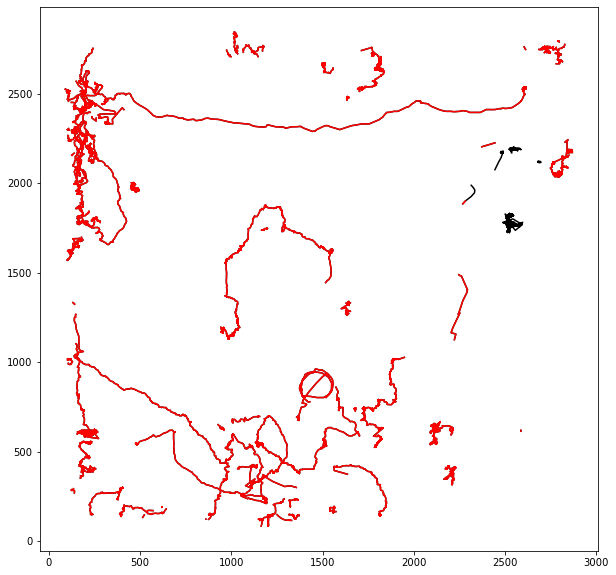

In [17]:
plt.figure(figsize=(10,10))

for ind in df.columns.get_level_values(1).unique():
    plt.plot(df[scorer, ind, 'head'].x, df[scorer, ind, 'head'].y, 'k')
    
for ind in df2.columns.get_level_values(1).unique():
    plt.plot(df2[scorer, ind, 'head'].x, df2[scorer, ind, 'head'].y, 'r')
    
# plt.xlim([380, 630])
# plt.ylim([2500, 2900])

In [18]:
newHdf = hdf = video_path[:-8] + 'clean.h5'
df2.to_hdf(newHdf, key="df_with_missing", mode="w")